In [130]:
# Celda 1: librerías básicas
import numpy as np
import pandas as pd
import os, random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks



import matplotlib.pyplot as plt

In [131]:
# Reproducibilidad total

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"  # intenta forzar determinismo en TF
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass

In [132]:
# Cargar el CSV
df = pd.read_csv("heart.csv")  # Cambia "heart.csv" si tu archivo tiene otro nombre
df.rename(columns={'HeartDisease': 'target'}, inplace=True)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,target
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [133]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  target          918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,target
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


# Preprocesamiento - Definición de variables y creación de dummies

In [134]:
df_dummies = pd.get_dummies(df, drop_first=True)

print(df_dummies.dtypes)

Age                    int64
RestingBP              int64
Cholesterol            int64
FastingBS              int64
MaxHR                  int64
Oldpeak              float64
target                 int64
Sex_M                   bool
ChestPainType_ATA       bool
ChestPainType_NAP       bool
ChestPainType_TA        bool
RestingECG_Normal       bool
RestingECG_ST           bool
ExerciseAngina_Y        bool
ST_Slope_Flat           bool
ST_Slope_Up             bool
dtype: object


In [135]:
df_dummies.shape #se agrgaron 6 variables más

(918, 16)

In [136]:
y = df_dummies['target']
X = df_dummies.drop('target', axis=1) #saco target de x

In [137]:
# Split 70/30 estratificado
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# --- Escalado SOLO a numéricas, fit en TRAIN y transform en TRAIN/TEST ---
from sklearn.preprocessing import StandardScaler

cols_to_scale = ['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak','Age']

scaler = StandardScaler()
X_train = X_train.copy()
X_test = X_test.copy()

X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale]  = scaler.transform(X_test[cols_to_scale])

In [138]:
# Partición fija de validación (desde X_train/Y_train escalados)
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

print(X_tr.shape, X_val.shape, X_test.shape)

(513, 15) (129, 15) (276, 15)


# MODELO A (una capa oculta)

## Defino la red

In [139]:
tf.random.set_seed(42)

# Modelo A: 1 capa oculta con 32 neuronas y ReLU
model_A = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),   # tantas entradas como columnas tenga X
    layers.Dense(32, activation='relu'),       # 1 capa oculta "simple"
    layers.Dense(1, activation='sigmoid')      # salida binaria: probabilidad 0..1
])
model_A.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_47 (Dense)                │ (None, 32)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545 (2.13 KB)

 Trainable params: 545 (2.13 KB)

 Non-trainable params: 0 (0.00 B)

## Compilo

In [140]:
model_A.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='AUC'),
             keras.metrics.Precision(name='Precision'),
             keras.metrics.Recall(name='Recall')]
)

## Entreno (con validación y early stopping)

In [141]:
# Entrenamiento del Modelo A (estable, con validación fija)
early_stop_A = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history_A = model_A.fit(
    X_tr, y_tr,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop_A],
    verbose=1,
    shuffle=False
)

# entrenamos varias épocas, pero frenamos solo cuando la validación deja de mejorar (para evitar sobreajuste).

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - AUC: 0.7321 - Precision: 0.6427 - Recall: 0.8832 - accuracy: 0.6744 - loss: 0.6392 - val_AUC: 0.8821 - val_Precision: 0.7791 - val_Recall: 0.9437 - val_accuracy: 0.8217 - val_loss: 0.5640
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8300 - Precision: 0.6945 - Recall: 0.8831 - accuracy: 0.7291 - loss: 0.5872 - val_AUC: 0.9109 - val_Precision: 0.8125 - val_Recall: 0.9155 - val_accuracy: 0.8372 - val_loss: 0.5179
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.8622 - Precision: 0.7589 - Recall: 0.8825 - accuracy: 0.7861 - loss: 0.5493 - val_AUC: 0.9193 - val_Precision: 0.8312 - val_Recall: 0.9014 - val_accuracy: 0.8450 - val_loss: 0.4803
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.8775 - Precision: 0.7838 - Recall: 0.8741 - accuracy: 0.8029 - loss: 0.5183 - val_AUC: 0.9228 - val_Precision: 0.8649 - val_Recall: 0.9014 - val_accuracy: 0.8682 - val_loss: 0.4494
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━

## Evaluar en TEST (métricas finales)

In [142]:
# --- Probabilidades y clase predicha (umbral 0.5)
proba_A = model_A.predict(X_test).ravel()
pred_A  = (proba_A >= 0.5).astype(int)

# --- Métricas finales (A)
acc_A = accuracy_score(y_test, pred_A)
f1_A  = f1_score(y_test, pred_A)
auc_A = roc_auc_score(y_test, proba_A)

# --- Métricas extra (A)
precision_A = precision_score(y_test, pred_A)
recall_A    = recall_score(y_test, pred_A)
error_A     = 1 - acc_A

print(f"Modelo A (1 capa) -> "
      f"Accuracy: {acc_A:.4f} | Error: {error_A:.4f} | "
      f"Precision: {precision_A:.4f} | Recall: {recall_A:.4f} | "
      f"F1: {f1_A:.4f} | AUC: {auc_A:.4f}")

# --- Tablita fácil (por ahora solo A)
res_dl = pd.DataFrame([{
    "Modelo": "DL – 1 capa (A)",
    "Accuracy": acc_A,
    "Error": error_A,
    "Precision": precision_A,
    "Recall": recall_A,
    "F1": f1_A,
    "AUC": auc_A
}]).round(4)

res_dl

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Modelo A (1 capa) -> Accuracy: 0.8877 | Error: 0.1123 | Precision: 0.8861 | Recall: 0.9150 | F1: 0.9003 | AUC: 0.9368


,Modelo,Accuracy,Error,Precision,Recall,F1,AUC
0,DL – 1 capa (A),0.8877,0.1123,0.8861,0.915,0.9003,0.9368


# MODELO B (dos capas ocultas)

*   Elemento de lista
*   Elemento de lista



## Defino la red

In [143]:
tf.random.set_seed(42)

model_B = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),   # 1ª capa oculta
    layers.Dense(16, activation='relu'),   # 2ª capa oculta
    layers.Dense(1, activation='sigmoid')  # salida binaria
])

model_B.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                │ (None, 32)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,057 (4.13 KB)

 Trainable params: 1,057 (4.13 KB)

 Non-trainable params: 0 (0.00 B)

## Compilo

In [144]:
model_B.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='AUC'),
             keras.metrics.Precision(name='Precision'),
             keras.metrics.Recall(name='Recall')]
)

## Entreno (con validación y early stopping)

In [145]:
early_stop_B = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history_B = model_B.fit(
    X_tr, y_tr,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop_B],
    verbose=1,
    shuffle=False
)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - AUC: 0.6984 - Precision: 0.7612 - Recall: 0.4989 - accuracy: 0.6476 - loss: 0.6537 - val_AUC: 0.8962 - val_Precision: 0.8194 - val_Recall: 0.8310 - val_accuracy: 0.8062 - val_loss: 0.5415
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8315 - Precision: 0.7775 - Recall: 0.7971 - accuracy: 0.7682 - loss: 0.5747 - val_AUC: 0.9129 - val_Precision: 0.8158 - val_Recall: 0.8732 - val_accuracy: 0.8217 - val_loss: 0.4822
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.8691 - Precision: 0.7657 - Recall: 0.8847 - accuracy: 0.7929 - loss: 0.5248 - val_AUC: 0.9183 - val_Precision: 0.8182 - val_Recall: 0.8873 - val_accuracy: 0.8295 - val_loss: 0.4394
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.8840 - Precision: 0.7850 - Recall: 0.8893 - accuracy: 0.8099 - loss: 0.4858 - val_AUC: 0.9222 - val_Precision: 0.8289 - val_Recall: 0.8873 - val_accuracy: 0.8372 - val_loss: 0.4072
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━

## Evaluar en TEST (métricas finales)

In [146]:

# Probabilidades y clase predicha (umbral 0.5)
proba_B = model_B.predict(X_test).ravel()
pred_B  = (proba_B >= 0.5).astype(int)

# Métricas finales
acc_B = accuracy_score(y_test, pred_B)
f1_B  = f1_score(y_test, pred_B)
auc_B = roc_auc_score(y_test, proba_B)

# Métricas extra
precision_B = precision_score(y_test, pred_B)
recall_B    = recall_score(y_test, pred_B)
error_B     = 1 - acc_B

print(f"Modelo B (2 capas) -> "
      f"Accuracy: {acc_B:.4f} | Error: {error_B:.4f} | "
      f"Precision: {precision_B:.4f} | Recall: {recall_B:.4f} | "
      f"F1: {f1_B:.4f} | AUC: {auc_B:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Modelo B (2 capas) -> Accuracy: 0.8913 | Error: 0.1087 | Precision: 0.8820 | Recall: 0.9281 | F1: 0.9045 | AUC: 0.9377


## Chequeo Overfiting

```
# Tiene formato de código
```



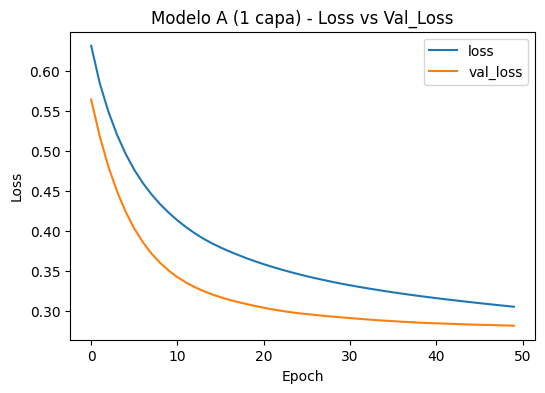

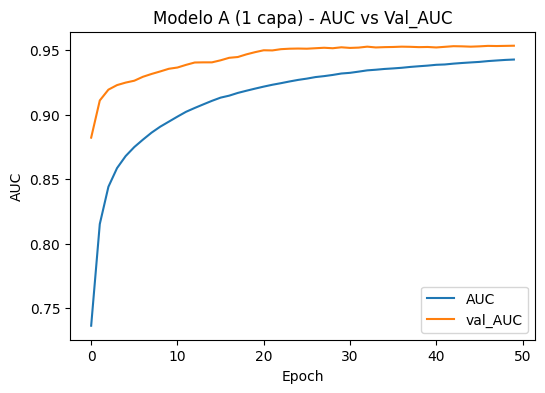

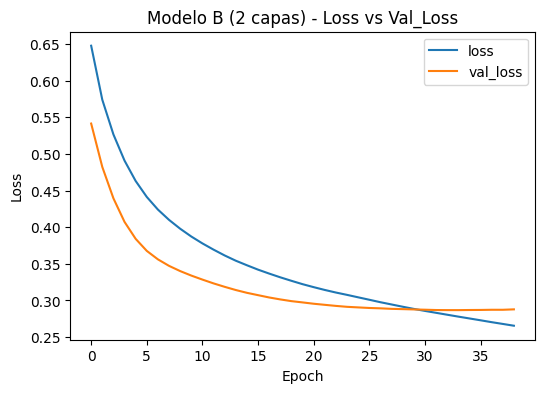

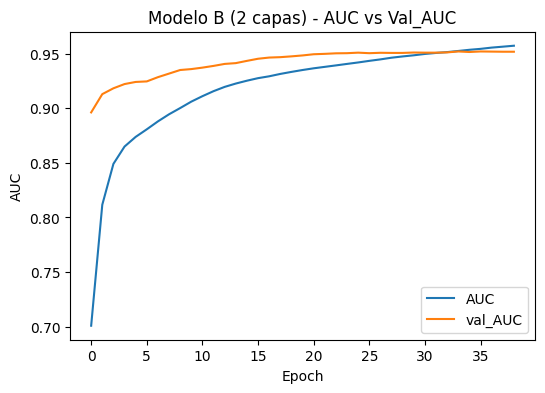

In [147]:
def plot_history(history, title=""):
    h = pd.DataFrame(history.history)
    ax = h[['loss','val_loss']].plot(figsize=(6,4))
    ax.set_title(f'{title} - Loss vs Val_Loss'); ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
    plt.show()
    if 'AUC' in h and 'val_AUC' in h:
        ax = h[['AUC','val_AUC']].plot(figsize=(6,4))
        ax.set_title(f'{title} - AUC vs Val_AUC'); ax.set_xlabel('Epoch'); ax.set_ylabel('AUC')
        plt.show()

plot_history(history_A, "Modelo A (1 capa)")
plot_history(history_B, "Modelo B (2 capas)")

# MODELO C (MODELO COMPLEJO)

##Defino la red


In [148]:
tf.random.set_seed(42)

model_C = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_C.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_52 (Dense)                │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,033 (15.75 KB)

 Trainable params: 3,841 (15.00 KB)

 Non-trainable params: 192 (768.00 B)

##Compilo

In [149]:
model_C.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='AUC'),
             keras.metrics.Precision(name='Precision'),
             keras.metrics.Recall(name='Recall')]
)

##Entreno con early stopping

In [150]:
early_stop_C = callbacks.EarlyStopping(
    monitor='val_loss', patience=7, restore_best_weights=True
)

history_C = model_C.fit(
    X_tr, y_tr,
    epochs=60,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop_C],
    verbose=1,
    shuffle=False
)

Epoch 1/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - AUC: 0.4798 - Precision: 0.5141 - Recall: 0.6026 - accuracy: 0.4823 - loss: 0.8316 - val_AUC: 0.7137 - val_Precision: 0.7302 - val_Recall: 0.6479 - val_accuracy: 0.6744 - val_loss: 0.6631
Epoch 2/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.7064 - Precision: 0.6597 - Recall: 0.7400 - accuracy: 0.6573 - loss: 0.6429 - val_AUC: 0.8752 - val_Precision: 0.8077 - val_Recall: 0.8873 - val_accuracy: 0.8217 - val_loss: 0.6082
Epoch 3/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - AUC: 0.8356 - Precision: 0.7643 - Recall: 0.8236 - accuracy: 0.7690 - loss: 0.5106 - val_AUC: 0.9066 - val_Precision: 0.8421 - val_Recall: 0.9014 - val_accuracy: 0.8527 - val_loss: 0.5589
Epoch 4/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.8789 - Precision: 0.7860 - Recall: 0.8780 - accuracy: 0.8061 - loss: 0.4626 - val_AUC: 0.9162 - val_Precision: 0.8667 - val_Recall: 0.9155 - val_accuracy: 0.8760 - val_loss: 0.5164
Epoch 5/60
17/17 ━━━━━━━━━━━━━━━━━━━

#Evaluo

In [151]:

precision_C = precision_score(y_test, pred_C)
recall_C    = recall_score(y_test, pred_C)
error_C     = 1 - acc_C

print(f"Modelo C (elaborado) -> Accuracy: {acc_C:.4f} | Error: {error_C:.4f} | Precision: {precision_C:.4f} | Recall: {recall_C:.4f} | F1: {f1_C:.4f} | AUC: {auc_C:.4f}")


Modelo C (elaborado) -> Accuracy: 0.8877 | Error: 0.1123 | Precision: 0.8812 | Recall: 0.9216 | F1: 0.9010 | AUC: 0.9377


#Resultados Finales

In [153]:
res_dl = pd.DataFrame([
    {"Modelo":"DL - 1 capa (A)",  "Accuracy":acc_A, "Error":error_A, "Precision":precision_A, "Recall":recall_A, "F1":f1_A, "AUC":auc_A},
    {"Modelo":"DL - 2 capas (B)", "Accuracy":acc_B, "Error":error_B, "Precision":precision_B, "Recall":recall_B, "F1":f1_B, "AUC":auc_B},
    {"Modelo":"DL - Elaborado (C)", "Accuracy":acc_C, "Error":error_C, "Precision":precision_C, "Recall":recall_C, "F1":f1_C, "AUC":auc_C},
]).round(4)

res_dl

,Modelo,Accuracy,Error,Precision,Recall,F1,AUC
0,DL - 1 capa (A),0.8877,0.1123,0.8861,0.9150,0.9003,0.9368
1,DL - 2 capas (B),0.8913,0.1087,0.8820,0.9281,0.9045,0.9377
2,DL - Elaborado (C),0.8877,0.1123,0.8812,0.9216,0.9010,0.9377


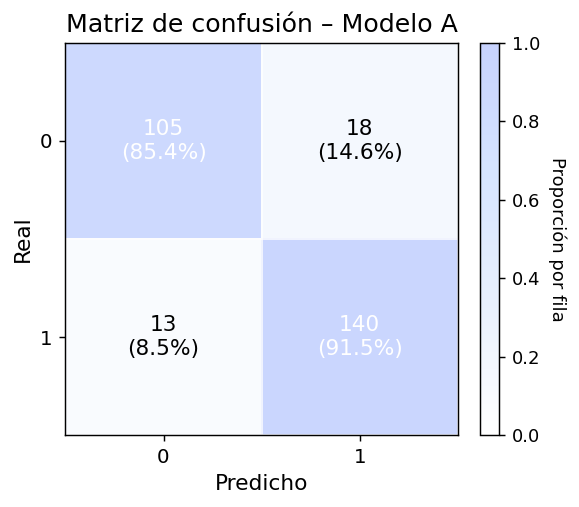

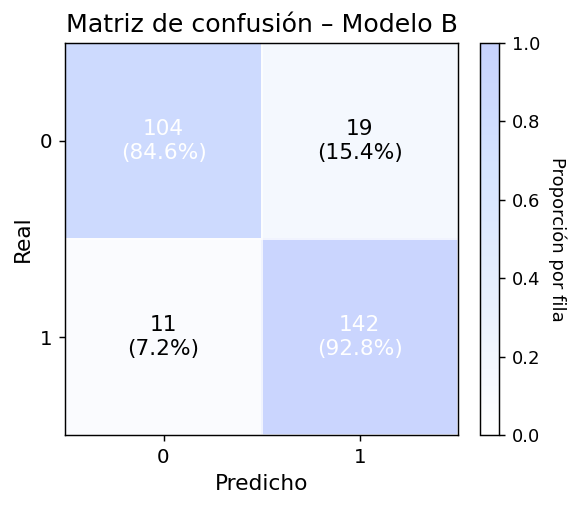

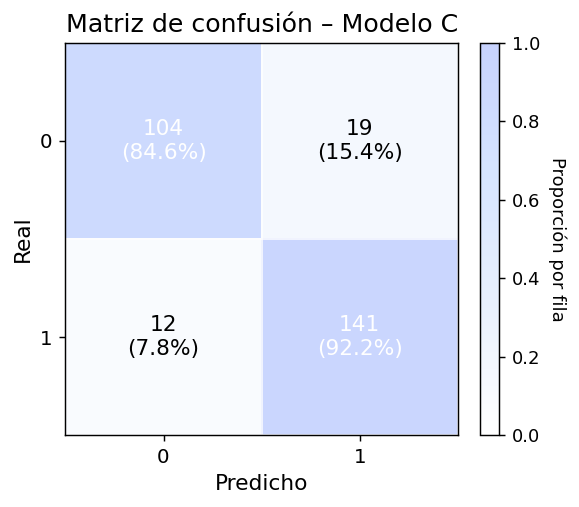

In [156]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix

plt.rcParams['font.family'] = 'DejaVu Sans'

def plot_cm_pretty(y_true, y_pred, title=""):
    cm = confusion_matrix(y_true, y_pred)
    cm_pct = cm / cm.sum(axis=1, keepdims=True)
    cmap = LinearSegmentedColormap.from_list("pastel_soft", ["#ffffff", "#e8f0fe", "#d6e4ff", "#c7d2fe"])
    fig, ax = plt.subplots(figsize=(5,4), dpi=130)
    im = ax.imshow(cm_pct, cmap=cmap, vmin=0, vmax=1)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Predicho", fontsize=12)
    ax.set_ylabel("Real", fontsize=12)
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["0","1"], fontsize=11)
    ax.set_yticklabels(["0","1"], fontsize=11)
    ax.set_xticks(np.arange(-.5, 2, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 2, 1), minor=True)
    ax.grid(which="minor", color="#ffffff", linestyle='-', linewidth=1, alpha=0.8)
    ax.tick_params(which="minor", bottom=False, left=False)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            txt_color = "black" if cm_pct[i, j] < 0.6 else "white"
            ax.text(j, i, f"{cm[i,j]}\n({cm_pct[i,j]*100:.1f}%)", ha="center", va="center", fontsize=12, color=txt_color)
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("Proporción por fila", rotation=-90, va="bottom", fontsize=10)
    plt.tight_layout()
    plt.show()

plot_cm_pretty(y_test, pred_A, "Matriz de confusión – Modelo A")
plot_cm_pretty(y_test, pred_B, "Matriz de confusión – Modelo B")
plot_cm_pretty(y_test, pred_C, "Matriz de confusión – Modelo C")